# Gender Classification
Ibrahim Mohammad (1618923)
imohammad@uh.edu


### Import Necessary Sklearn and pandas packages

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD, PCA, SparsePCA
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC

### Imports for Visualization

In [2]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.features import Manifold
from yellowbrick.text import TSNEVisualizer
from yellowbrick.model_selection import LearningCurve

## Reading the data
There are exactly 6 documents which are null, we need to drop those records. Target labels are mix of both upper and lower case characters and few target classes are padded with spaces. We need to trim and convert to either upper case or lower case characters. Otherwise there is a huge difference in prediction.

In [3]:
df = pd.read_excel('blog-gender-dataset.xlsx', sheet_name='training', header = None, usecols=[0,1],  names=['blog', 'gender'])
tdf = df.dropna().copy();
tdf['blog'] = tdf['blog'].astype(str)
tdf["gender"] = tdf["gender"].map(lambda x: 1 if x.strip().lower()=='m' else 0)

## Preprocessing 

In [4]:
def convertSpecial(row):
    row = row.replace('???', ' foundQQQMark ')
    row = row.replace('??', ' foundQQMark ')
    row = row.replace(':)', ' foundHsmiley ')
    row = row.replace(':(', ' foundSsmiley ')
    row = row.replace('!!!', ' foundEEEmark ')
    row = re.sub(r'(\d+\.\d+)|(\d+x\d)|(\d+)|(\_)', '', row)
    return row

tdf['blog'] = tdf['blog'].map(convertSpecial);

## Vectorizing 
Vectorize articles based on bigram and remove stop words. Considering top 100,000 features.

In [5]:
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    smooth_idf=True,
    max_features=100000
)
vec = tfidf.fit_transform(tdf['blog'])
print('Initial Vector Size', vec.shape)

Initial Vector Size (3226, 100000)


## Feature Selection from Model

In [6]:
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import StratifiedKFold
sfmodel_1 = SelectFromModel(SGDClassifier(loss='hinge', penalty='elasticnet',alpha=0.0001, random_state=42,max_iter=500, tol=1e-3).fit(vec, tdf['gender']), prefit=True)
newVec = sfmodel_1.transform(vec)
print("Intermediate Vector size", newVec.shape)
sfmodel_2 = SelectFromModel(SGDClassifier(loss='hinge', penalty='elasticnet',alpha=0.0001, random_state=42,max_iter=500, tol=1e-3).fit(newVec, tdf['gender']), prefit=True)
finalVec = sfmodel_2.transform(newVec)
print("Final Vector size", finalVec.shape)

Intermediate Vector size (3226, 23442)
Final Vector size (3226, 8164)


## Splitting the data in 7:3 ratio as Train and Test. Stratified based on gender

In [7]:
X_train ,X_test, y_train, y_test = train_test_split(finalVec, tdf['gender'], test_size=0.30, stratify=tdf['gender'])

## Grid Search Cross Validation
Creating a pipeline for Hyperparameter tuning using GridSearch cross validation

In [8]:
steps = [('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001, random_state=42,max_iter=500, tol=1e-3))]     
text_clf = Pipeline(steps)
parameters = {
    'clf__alpha': (0.0001,0.001, 0.01),
    'clf__penalty':('l2', 'elasticnet')
}
gs_clf = GridSearchCV(text_clf, parameters, cv=10, iid=False, n_jobs=-1)

## Training the model and Predicting target class

In [9]:
gs_clf.fit(X_train.toarray(), y_train)
y_pred = gs_clf.predict(X_test.toarray())
print("Classification Report:", metrics.classification_report(y_test, y_pred))
print("Accuracy Score: ", metrics.accuracy_score(y_test, y_pred))
print("Number of Train features: ", X_train.shape)
print("Number of Test features: ", X_test.shape)

Classification Report:               precision    recall  f1-score   support

           0       0.92      0.85      0.88       464
           1       0.87      0.93      0.90       504

   micro avg       0.89      0.89      0.89       968
   macro avg       0.90      0.89      0.89       968
weighted avg       0.89      0.89      0.89       968

Accuracy Score:  0.8925619834710744
Number of Train features:  (2258, 8164)
Number of Test features:  (968, 8164)


In [10]:
print("Best Score", gs_clf.best_score_)
print("Best Parameters", gs_clf.best_params_)
print("Stats for the model", gs_clf.cv_results_)

Best Score 0.8657758198727361
Best Parameters {'clf__alpha': 0.0001, 'clf__penalty': 'l2'}
Stats for the model {'mean_fit_time': array([ 2.66500285, 14.05646944,  2.89500725,  7.30371778,  1.3920517 ,
        2.2363765 ]), 'std_fit_time': array([0.24832222, 1.87746406, 0.59776357, 1.34375706, 0.10516082,
       0.20711701]), 'mean_score_time': array([0.00385642, 0.00469029, 0.00588562, 0.00648575, 0.0084785 ,
       0.00509138]), 'std_score_time': array([0.00477075, 0.00161192, 0.00150862, 0.00205556, 0.00469561,
       0.00069312]), 'param_clf__alpha': masked_array(data=[0.0001, 0.0001, 0.001, 0.001, 0.01, 0.01],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__penalty': masked_array(data=['l2', 'elasticnet', 'l2', 'elasticnet', 'l2',
                   'elasticnet'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__alpha': 0.0001,

## Classification Report

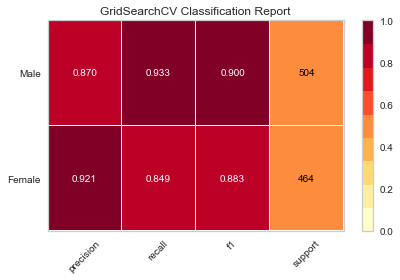

In [11]:
classes = ["Female", "Male"]
cr_viz = ClassificationReport(gs_clf, classes=classes, support=True)
cr_viz.fit(X_train.toarray(), y_train)  # Fit the visualizer and the model
cr_viz.score(X_test.toarray(), y_test)  # Evaluate the model on the test data
cr_viz.poof(outpath="graphs/cr.png")
cr_viz.poof()

## Confusion Matrix

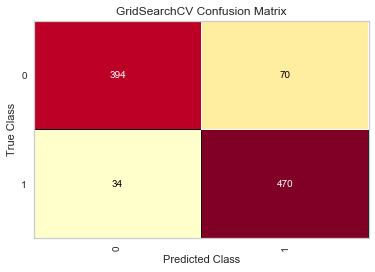

In [12]:
cm_viz = ConfusionMatrix(gs_clf)
cm_viz.fit(X_train.toarray(), y_train)
cm_viz.score(X_test.toarray(), y_test)
cm_viz.poof(outpath="graphs/cm.png")
cm_viz.poof()

## Area Under the Curve

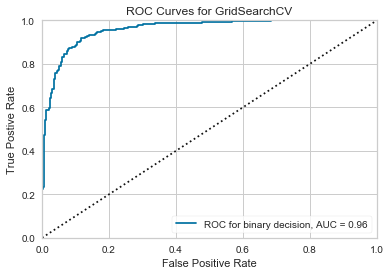

In [13]:
auc_viz = ROCAUC(gs_clf, classes=['Female', 'Male'], micro=False, macro=False, per_class=False)
auc_viz.fit(X_train, y_train)  # Fit the training data to the visualizer
auc_viz.score(X_test, y_test)  # Evaluate the model on the test data
auc_viz.poof(outpath="graphs/auroc.png")
auc_viz.poof()

## Precision Recall Curve

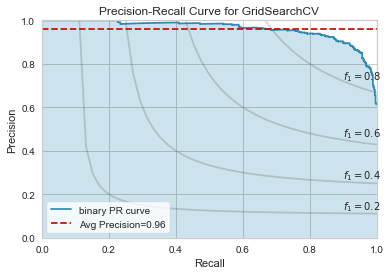

In [14]:
prc_viz = PrecisionRecallCurve(gs_clf, iso_f1_curves=True,per_class=True,fill_area=True, micro=False)
prc_viz.fit(X_train, y_train)
prc_viz.score(X_test, y_test)
prc_viz.poof(outpath="graphs/prc.png")
prc_viz.poof()

## Class Prediction Error

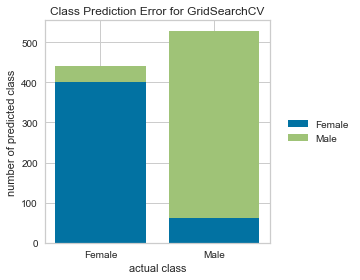

In [15]:
cpe_viz = ClassPredictionError(gs_clf, classes=classes)
cpe_viz.fit(X_train, y_train)
# Evaluate the model on the test data
cpe_viz.score(X_test, y_test)
# Draw visualization
cpe_viz.poof(outpath="graphs/cpe.png")
cpe_viz.poof()

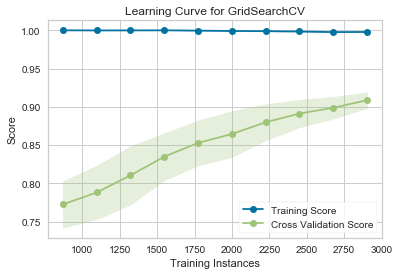

In [16]:
sizes = np.linspace(0.3, 1.0, 10)
lr_viz = LearningCurve(gs_clf,cv=10, train_sizes=sizes,
    scoring='f1_weighted', n_jobs=4 )
lr_viz.fit(finalVec, tdf['gender'])
lr_viz.poof(outpath="graphs/lr.png")
lr_viz.poof()

### TSNE projection of total documents
Projection of document similarity onto 2 dimensional space

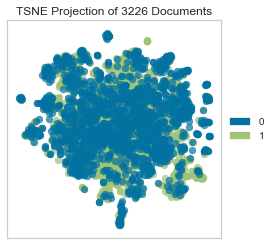

In [17]:
tsne = TSNEVisualizer()
tsne.fit(finalVec, tdf['gender'])
tsne.poof(outpath="graphs/tsnedoc.png")
tsne.poof()

## Implementation using Deep Learning 
Import Necessary Keras packages to create a Neural Network

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

### Create a Sequential Model with 6 hidden layers each with 100 nodes
Each hidden layer uses ReLU activation function and Output layer uses sofmax activation. Stopping criteria for the model is after no change in 2 successive epochs.

In [19]:
model = Sequential()
#Convert target labels to categorical data for classification
target = to_categorical(tdf['gender'])
#Building a deep neural network of 6 hidden layers each with 100 units and each with ReLU activation function
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
#Create output layer of 2 nodes with softmax activation function
model.add(Dense(units=2, activation='softmax'))

In [20]:
#Stopping criteria for the model after no change in 2 successive epochs
early_stopping_monitor = EarlyStopping(patience=2)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(finalVec.toarray(), target, epochs=10, validation_split=0.3, callbacks=[early_stopping_monitor])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2258 samples, validate on 968 samples
Epoch 1/10
2258/2258 [==============================] - 2s 873us/step - loss: 0.6261 - acc: 0.6165 - val_loss: 0.3880 - val_acc: 0.8440
Epoch 2/10
2258/2258 [==============================] - 2s 693us/step - loss: 0.1268 - acc: 0.9548 - val_loss: 0.2321 - val_acc: 0.9163
Epoch 3/10
2258/2258 [==============================] - 2s 720us/step - loss: 0.0070 - acc: 0.9991 - val_loss: 0.3161 - val_acc: 0.9174
Epoch 4/10
2258/2258 [==============================] - 2s 731us/step - loss: 2.7326e-04 - acc: 1.0000 - val_loss: 0.3714 - val_acc: 0.9194
